<a href="https://colab.research.google.com/github/Qmo37/VAE_MNIST/blob/master/VAE_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE MNIST - 變分自編碼器手寫數字重建

使用 Colab 展示如何使用變分自編碼器（Variational Autoencoder, VAE）來重建 MNIST 手寫數字。

## 作業要求
- 使用 MNIST 資料集
- 實作 VAE (Encoder + Decoder)
- Reparameterization trick
- Adam 優化器
- 顯示每個 epoch 平均損失
- 輸出重建圖像

## 1. 環境設置與套件導入

In [1]:
# 安裝必要套件（如果需要）
# !pip install torch torchvision matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os

# 設置設備
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'使用設備: {device}')

# 設置隨機種子以確保結果可重現
torch.manual_seed(42)
np.random.seed(42)

使用設備: cuda


## 2. VAE 模型定義

### 模型架構
```
編碼器: 784 → 400 → (mu=20, logvar=20)
解碼器: 20 → 400 → 784
```

In [2]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()

        # 編碼器: 784 -> 400 -> (mu, logvar)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # 解碼器: latent_dim -> 400 -> 784
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        """編碼器：將輸入轉換為潛在空間參數"""
        h1 = F.relu(self.fc1(x))
        mu = self.fc_mu(h1)
        logvar = self.fc_logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """重參數化技巧: z = mu + std * epsilon"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        """解碼器：將潛在變數轉換回圖像"""
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# 初始化模型
model = VAE().to(device)
print(f'模型參數數量: {sum(p.numel() for p in model.parameters()):,}')

模型參數數量: 652,824


## 3. 損失函數定義

VAE 損失 = 重建損失 + KL 散度損失

In [3]:
def vae_loss(recon_x, x, mu, logvar):
    """
    VAE 損失函數

    Args:
        recon_x: 重建的圖像
        x: 原始圖像
        mu: 潛在空間均值
        logvar: 潛在空間對數方差
    """
    # 重建損失 (Binary Cross Entropy)
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # KL 散度損失
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

## 4. 資料載入 (MNIST)

正在載入 MNIST 資料集...


100%|██████████| 9.91M/9.91M [00:00<00:00, 21.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 497kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.67MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.0MB/s]
/tmp/ipython-input-2352608354.py:30: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2352608354.py:30: UserWarning: Glyph 31844 (\N{CJK UNIFIED IDEOGRAPH-7C64}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


訓練資料: 60000 張圖像
測試資料: 10000 張圖像


/tmp/ipython-input-2352608354.py:30: UserWarning: Glyph 27171 (\N{CJK UNIFIED IDEOGRAPH-6A23}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2352608354.py:30: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2352608354.py:30: UserWarning: Glyph 22294 (\N{CJK UNIFIED IDEOGRAPH-5716}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2352608354.py:30: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31844 (\N{CJK UNIFIED IDEOGRAPH-7C64}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(byte

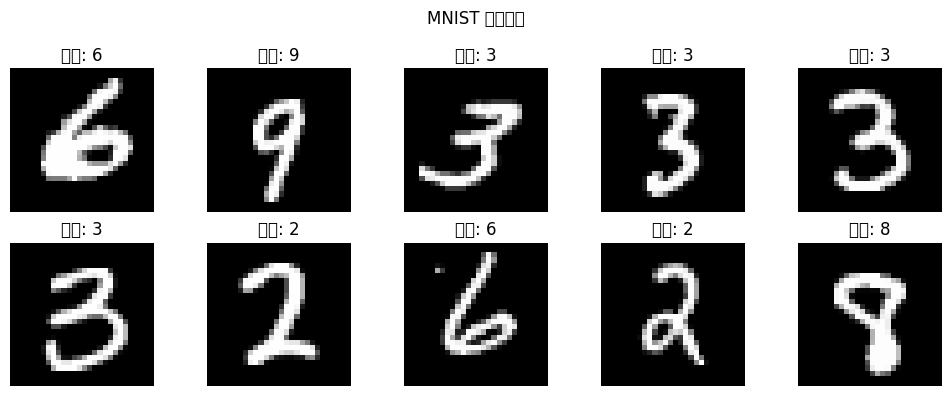

In [4]:
print("正在載入 MNIST 資料集...")

# 資料轉換
transform = transforms.Compose([transforms.ToTensor()])

# 載入資料集
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

# 資料載入器
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f"訓練資料: {len(train_dataset)} 張圖像")
print(f"測試資料: {len(test_dataset)} 張圖像")

# 顯示一些樣本圖像
def show_sample_images():
    data_iter = iter(train_loader)
    images, labels = next(data_iter)

    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i in range(10):
        row, col = i // 5, i % 5
        axes[row, col].imshow(images[i].squeeze(), cmap='gray')
        axes[row, col].set_title(f'標籤: {labels[i].item()}')
        axes[row, col].axis('off')

    plt.suptitle('MNIST 樣本圖像')
    plt.tight_layout()
    plt.show()

show_sample_images()

## 5. 訓練設置

In [5]:
# Adam 優化器 (作業要求)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練函數
def train(epoch):
    model.train()
    train_loss = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        # 前向傳播
        recon_batch, mu, logvar = model(data)

        # 計算損失
        loss = vae_loss(recon_batch, data, mu, logvar)

        # 反向傳播
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # 進度顯示
        if batch_idx % 200 == 0:
            print(f'訓練 Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\t'
                  f'損失: {loss.item() / len(data):.6f}')

    # 計算該 epoch 的平均損失
    avg_loss = train_loss / len(train_loader.dataset)
    print(f'====> Epoch: {epoch} 平均損失: {avg_loss:.4f}')
    return avg_loss

## 6. 執行訓練 (5 個 epochs)

開始訓練...
訓練 Epoch: 1 [0/60000 (0%)]	損失: 547.923157
訓練 Epoch: 1 [25600/60000 (43%)]	損失: 147.766418
訓練 Epoch: 1 [51200/60000 (85%)]	損失: 131.596481
====> Epoch: 1 平均損失: 163.5888
訓練 Epoch: 2 [0/60000 (0%)]	損失: 122.051559
訓練 Epoch: 2 [25600/60000 (43%)]	損失: 119.785950
訓練 Epoch: 2 [51200/60000 (85%)]	損失: 116.810265
====> Epoch: 2 平均損失: 120.7739
訓練 Epoch: 3 [0/60000 (0%)]	損失: 114.757301
訓練 Epoch: 3 [25600/60000 (43%)]	損失: 107.883537
訓練 Epoch: 3 [51200/60000 (85%)]	損失: 115.105080
====> Epoch: 3 平均損失: 114.2100
訓練 Epoch: 4 [0/60000 (0%)]	損失: 109.903870
訓練 Epoch: 4 [25600/60000 (43%)]	損失: 115.189209
訓練 Epoch: 4 [51200/60000 (85%)]	損失: 113.059448
====> Epoch: 4 平均損失: 111.4041
訓練 Epoch: 5 [0/60000 (0%)]	損失: 109.838501
訓練 Epoch: 5 [25600/60000 (43%)]	損失: 112.322220
訓練 Epoch: 5 [51200/60000 (85%)]	損失: 110.184059
====> Epoch: 5 平均損失: 109.6982
訓練完成！


/tmp/ipython-input-982182849.py:21: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-982182849.py:21: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-982182849.py:21: UserWarning: Glyph 25613 (\N{CJK UNIFIED IDEOGRAPH-640D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-982182849.py:21: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-982182849.py:21: UserWarning: Glyph 35347 (\N{CJK UNIFIED IDEOGRAPH-8A13}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-982182849.py:21: UserWarning: Glyph 32244 (\N{CJK UNIFIED IDEOGRAPH-7DF4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-982182849.py:21: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from

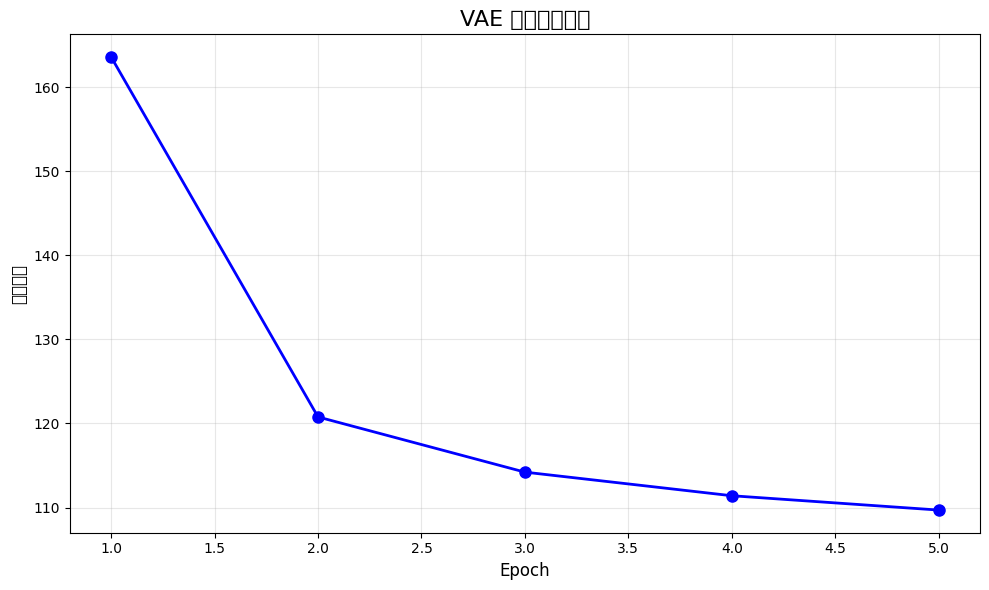


📊 訓練總結:
• 最終損失: 109.6982
• 損失改善: 53.8906


In [6]:
print("開始訓練...")
print("="*50)

epochs = 5  # 作業要求的 epoch 數
losses = []

for epoch in range(1, epochs + 1):
    avg_loss = train(epoch)
    losses.append(avg_loss)

print("="*50)
print("訓練完成！")

# 繪製損失曲線
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), losses, 'b-o', linewidth=2, markersize=8)
plt.title('VAE 訓練損失曲線', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('平均損失', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n訓練總結:")
print(f"• 最終損失: {losses[-1]:.4f}")
print(f"• 損失改善: {losses[0] - losses[-1]:.4f}")

## 7. 結果視覺化

顯示原始圖像與重建圖像的比較

生成重建結果...


/tmp/ipython-input-3573614770.py:30: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3573614770.py:30: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3573614770.py:30: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3573614770.py:30: UserWarning: Glyph 24314 (\N{CJK UNIFIED IDEOGRAPH-5EFA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3573614770.py:30: UserWarning: Glyph 32080 (\N{CJK UNIFIED IDEOGRAPH-7D50}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3573614770.py:30: UserWarning: Glyph 26524 (\N{CJK UNIFIED IDEOGRAPH-679C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3573614770.py:30: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missi

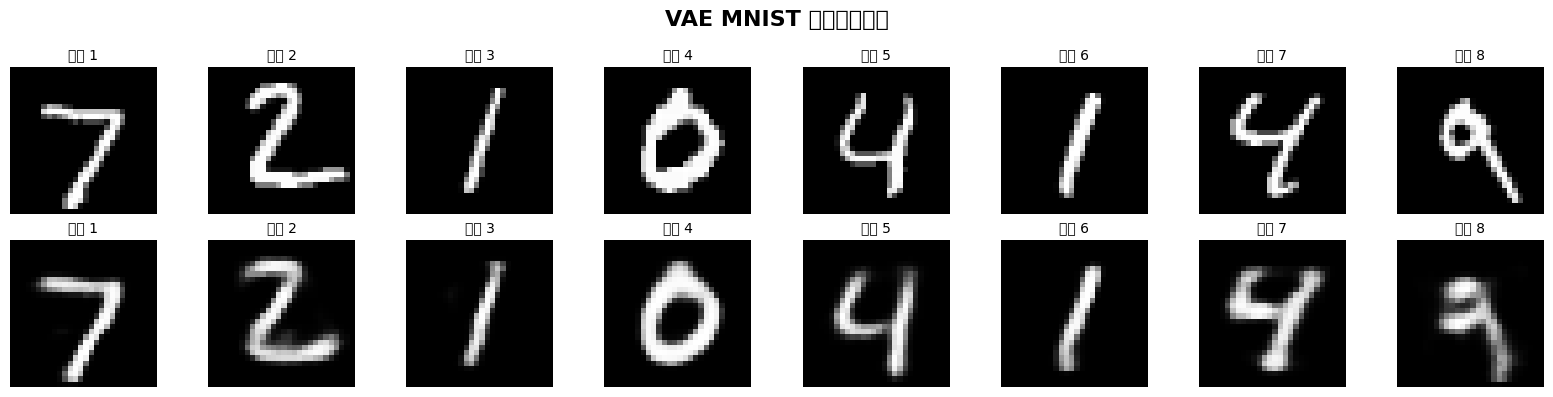

✅ 重建結果生成完成！


In [7]:
print("生成重建結果...")

model.eval()
with torch.no_grad():
    # 取得測試資料
    data, _ = next(iter(test_loader))
    data = data.to(device)

    # 選擇 8 個樣本進行視覺化
    test_samples = data[:8]

    # 重建
    recon_samples, _, _ = model(test_samples)

    # 創建比較圖
    fig, axes = plt.subplots(2, 8, figsize=(16, 4))

    for i in range(8):
        # 原始圖像
        axes[0, i].imshow(test_samples[i].cpu().view(28, 28), cmap='gray')
        axes[0, i].set_title(f'原始 {i+1}', fontsize=10)
        axes[0, i].axis('off')

        # 重建圖像
        axes[1, i].imshow(recon_samples[i].cpu().view(28, 28), cmap='gray')
        axes[1, i].set_title(f'重建 {i+1}', fontsize=10)
        axes[1, i].axis('off')

    plt.suptitle('VAE MNIST 重建結果比較', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("重建結果生成完成！")

## 8. 額外展示：從潛在空間生成新圖像

/tmp/ipython-input-1133915881.py:19: UserWarning: Glyph 24478 (\N{CJK UNIFIED IDEOGRAPH-5F9E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1133915881.py:19: UserWarning: Glyph 28507 (\N{CJK UNIFIED IDEOGRAPH-6F5B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1133915881.py:19: UserWarning: Glyph 22312 (\N{CJK UNIFIED IDEOGRAPH-5728}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1133915881.py:19: UserWarning: Glyph 31354 (\N{CJK UNIFIED IDEOGRAPH-7A7A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1133915881.py:19: UserWarning: Glyph 38291 (\N{CJK UNIFIED IDEOGRAPH-9593}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1133915881.py:19: UserWarning: Glyph 29983 (\N{CJK UNIFIED IDEOGRAPH-751F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1133915881.py:19: UserWarning: Glyph 25104 (\N{CJK UNIFIED IDEOGRAPH-6210}) missi

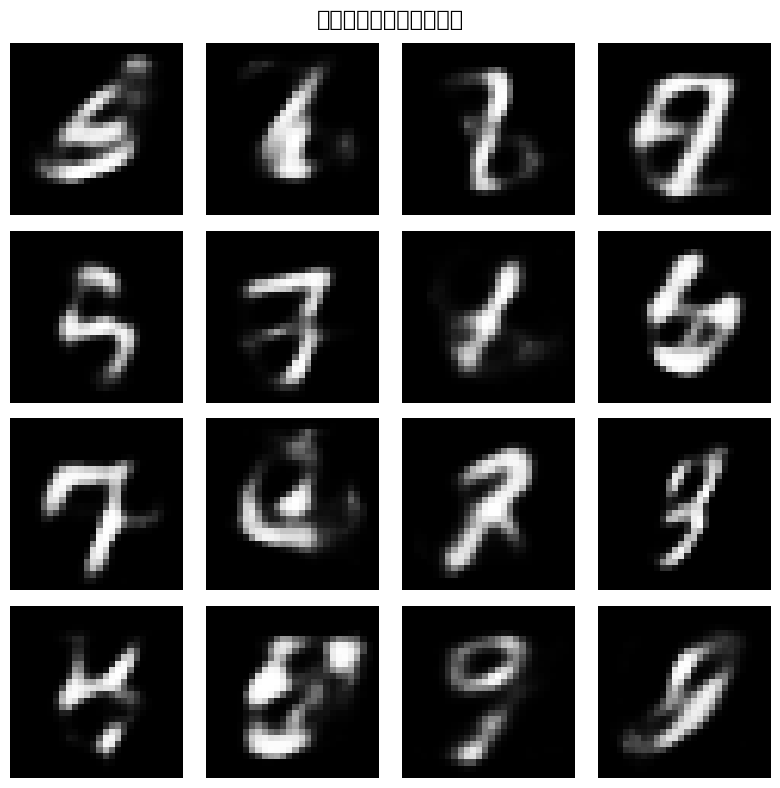

🎨 新圖像生成完成！


In [8]:
# 從潛在空間隨機採樣生成新圖像
model.eval()
with torch.no_grad():
    # 從標準正態分佈中採樣
    z = torch.randn(16, 20).to(device)

    # 解碼生成圖像
    generated = model.decode(z)

    # 顯示生成的圖像
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))

    for i in range(16):
        row, col = i // 4, i % 4
        axes[row, col].imshow(generated[i].cpu().view(28, 28), cmap='gray')
        axes[row, col].axis('off')

    plt.suptitle('從潛在空間生成的新圖像', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("新圖像生成完成！")

## 9. 作業總結

| 要求項目 | 完成狀態 | 說明 |
|---------|---------|------|
| 使用 MNIST 資料集 | ✅ | 自動下載並載入 MNIST 資料集 |
| Encoder 實作 | ✅ | 784 → 400 → (mu, logvar) |
| Reparameterization trick | ✅ | z = mu + std * epsilon |
| Decoder 實作 | ✅ | 20 → 400 → 784 |
| Adam 優化器 | ✅ | 學習率 0.001 |
| 顯示 epoch 損失 | ✅ | 每個 epoch 顯示平均損失 |
| 輸出重建圖像 | ✅ | 原始 vs 重建圖像比較 |

